In [37]:
# import or define evaluate_classification, plot_decision_boundary, plot_data

from sklearn.datasets import make_classification, make_moons
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
def load_dataset(filename, data_columns, target_column):
    """Load dataset from CSV file.

    Args:
        filename (str): Path to CSV file.
        data_columns (list): List of column names for data.
        target_column (str): Name of target column.

    Returns:
        tuple: Tuple containing data and target.
    """
    
    df = pd.read_csv(filename)
    X, y = df[data_columns], df[target_column]
    return X.values, y.values.reshape(-1, 1)

In [39]:
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error, mean_squared_log_error,
                             r2_score)


def evaluate_regression(y_true, y_pred, use_log = False):
    """Evaluate regression model performance.

    Args:
        y_true (array): Ground truth values.
        y_pred (array): Predicted values.

    Returns:
        dict: Dictionary containing evaluation metrics.
    """
    metrics = {
        'mae': mean_absolute_error(y_true, y_pred),
        'mse': mean_squared_error(y_true, y_pred),
        'rmse': mean_squared_error(y_true, y_pred, squared=False),
        'r2': r2_score(y_true, y_pred)
    }
    if use_log:
        metrics['msle'] = mean_squared_log_error(y_true, y_pred)
    return metrics

def evaluate_classification(y_true, y_pred, labels = None):
    """
    Evaluate classification model performance.

    Args:
        y_true (array): Ground truth values.
        y_pred (array): Predicted values.
        labels (list): List of labels to index the matrix.

    Returns:
        accuracy (float): Accuracy score.
        report (pd.DataFrame): Classification report.
        confusion_matrix (pd.DataFrame): Confusion matrix.
    """
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    confusion = pd.DataFrame(confusion_matrix(y_true, y_pred), labels, labels)
    return accuracy, report, confusion

In [40]:
import matplotlib.colors as mcolors
import torch


'''
def plot_data(X, y):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
'''

def plot_decision_boundary(model, X, y):
    x_span = np.linspace(min(X[:, 0]) - 0.25, max(X[:, 0]) + 0.25, 50)
    y_span = np.linspace(min(X[:, 1]) - 0.25, max(X[:, 1]) + 0.25, 50)
    xx, yy = np.meshgrid(x_span, y_span)
    xx_, yy_ = xx.ravel(), yy.ravel()
    grid = np.c_[xx_, yy_]
    if hasattr(model, "predict_proba"):
        pred_func = model.predict_proba(grid)[:,0]
    else:
        # check if torch model
        if hasattr(model, "forward"):
            pred_func = 1 - model(torch.tensor(grid, dtype=torch.double)).detach().numpy()
        else:
            pred_func = 1 - model(grid).numpy()
    z = pred_func.reshape(xx.shape)
    c = plt.contourf(xx, yy, z, cmap="RdYlGn")
    plt.colorbar(c)
    colors = list(mcolors.TABLEAU_COLORS.keys())
    color_values = [colors[int(label)] for label in y]
    plt.scatter(X[:, 0], X[:, 1], marker="x", c=color_values)

In [41]:
class LogisticRegression:
    """Logistic Regression Classifier."""
    def __init__(self, standardize=True, 
                 learning_rate=0.01, 
                 max_iter=1000,
                 tol=1e-4,
                 verbose=False):
        """Initialize Logistic Regression Classifier.
        
        Args:
            standardize (bool): Whether to standardize the data.
            learning_rate (float): Learning rate for gradient descent.
            max_iter (int): Maximum number of iterations for gradient descent.
            tol (float): Tolerance for gradient descent.
            verbose (bool): Whether to print cost at each 100th iteration.
        """
        self.standardize = standardize
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose

    def normalize(self, X):
        """Normalize the data.
        
        Args:
            X (array): Data to normalize.
        
        Returns:
            tuple: Tuple containing normalized data, mean, and standard deviation.
        """
        # TODO: Implement
        mean = X.mean()
        std = X.std()
        X_new = (X-mean)/std
        return X_new, mean, std

    def add_intercept(self, X):
        """Add intercept term to the data.
        
        Args:
            X (array): Data to add intercept term.
        
        Returns:
            array: Data with intercept term."""
        m = X.shape[0]
        ones = np.ones((m, 1))
        X_new = np.column_stack((ones, X))
        return X_new

    def sigmoid(self, z):
        """Sigmoid function.
        
        Args:
            z (array): Input to sigmoid function.
            
        Returns:
            array: Output of sigmoid function."""
        # TODO: Implement
        h = 1/(1+np.exp(-1*z))
        return h
    
    def hypothesis(self, X, theta):
        """Hypothesis function.
        
        Args:
            X (array): Data.
            theta (array): Parameters.
        
        Returns:
            array: Output of hypothesis function."""
        # TODO: Implement
        z = np.matmul(X, theta.reshape((theta.shape[0],1)))
        return self.sigmoid(z)

    def cost_function(self, X, y, theta):
        """Cost function.
        
        Args:
            X (array): Data.
            y (array): Target.
            theta (array): Parameters.
            
        Returns:
            float: Cost of hypothesis function."""
        # TODO: Implement
        cost = (1/X.shape[0])*(-np.matmul(y.reshape(1, -1),np.log(self.hypothesis(X, theta))) - 
                               np.matmul((1-y).reshape(1, -1), np.log(1-self.hypothesis(X, theta))))
        return cost

    def gradient(self, X, y, theta):
        """Gradient of cost function.
        
        Args:
            X (array): Data.
            y (array): Target.
            theta (array): Parameters.
            
        Returns:
            array: Gradient of cost function."""
        # TODO: Implement
        grad = (1/X.shape[0])*np.matmul((self.hypothesis(X, theta)-y).reshape(1, X.shape[0])[0], X)
        return grad

    def gradient_descent(self, X, y, theta):
        """Gradient descent algorithm.

        Args:
            X (array): Data.
            y (array): Target.
            theta (array): Parameters.
        
        Returns:
            tuple: Tuple containing parameters and costs."""
        costs = []
        J = self.cost_function(X, y, theta)
        costs.append(J)

        if self.verbose:
            print(f"Iteration 0 Cost: {J}")

        for i in range(1, self.max_iter + 1):
            # TODO: Implement
            grad = self.gradient(X, y, theta)
            theta = theta - self.learning_rate * grad
            cost = self.cost_function(X, y, theta)
            
            costs.append(cost)

            if i % 100 == 0 and self.verbose:
                print(f"Iteration {i} Cost: {cost}")

            if np.abs(costs[i] - costs[i - 1]) < self.tol:
                print(f"Converged at iteration {i}")
                break

        return theta, costs
    
    def fit(self, X, y):
        """Fit the model.

        Args:
            X (array): Data.
            y (array): Target."""
        X_new = X.copy()
        if self.standardize:
            X_new, self.mean, self.std = self.normalize(X_new)
        X_new = self.add_intercept(X_new)

        self.theta = np.zeros(X_new.shape[1])
        self.theta, self.costs = self.gradient_descent(X_new, y, self.theta)

    def predict(self, X):
        """Predict the target.

        Args:
            X (array): Data.

        Returns:
            array: Predicted target."""
        X_new = X.copy()
        # TODO: Implement
        if self.standardize:
            X_new = self.normalize(X_new)[0]
        
        X_new = self.add_intercept(X_new)

        y_pred = np.where(self.hypothesis(X_new, self.theta)>=0.5, 1, 0)
        return y_pred

    def predict_proba(self, X):
        """Predict the probability of target.
        
        Args:
            X (array): Data.
        
        Returns:
            array: Predicted probability of target."""
        X_new = X.copy()
        # TODO: Implement
        if self.standardize:
            X_new = self.normalize(X_new)[0]
        X_new = self.add_intercept(X_new)

        h = self.hypothesis(X_new, self.theta)
        return np.column_stack((1-h, h))

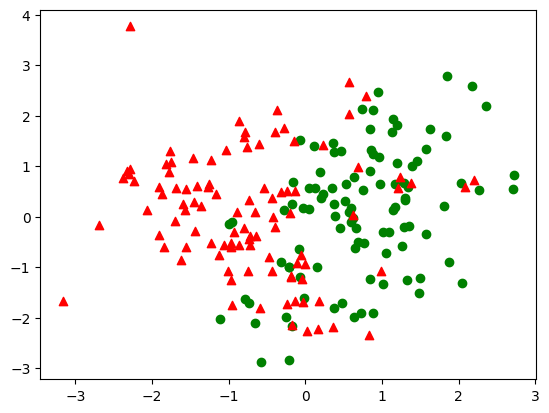

In [42]:
def plot_data(X, y):
    
    plt.scatter(X[y==1,0], X[y==1,1], marker='o', c='green')
    plt.scatter(X[y==0,0], X[y==0,1], marker='^', c='red')
    plt.show()

'''
def plot_decision_boundary(lr, X, y):
    
    plt.scatter(X[y==1,0], X[y==1,1], marker='^', c='green')
    plt.scatter(X[y==0,0], X[y==0,1], marker='^', c='red')
    plt.show()    
'''
X, y = make_classification(n_samples = 200, n_classes = 2, n_features = 2, 
                           n_informative=2, n_redundant=0, random_state = 42,
                           flip_y=0.02, class_sep=0.8)

#print(X, y)
plot_data(X, y)


In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_test)

[[-1.46395194  1.1611363 ]
 [ 1.26489635 -0.57618598]
 [ 0.59998239  0.1775701 ]
 [ 0.60121759 -0.10851805]
 [-1.81941768  1.04007772]
 [-2.2914064   0.94783609]
 [-0.1637889   0.68994647]
 [-1.41869386  0.60775694]
 [ 0.38498383  0.01686923]
 [-0.47238155 -0.80567437]
 [ 0.68454539  0.98669675]
 [ 2.2024978   0.73945925]
 [ 0.78678403  2.39668422]
 [-0.03534423 -1.67811585]
 [-1.25749712  0.65469335]
 [ 0.96596854  1.17555289]
 [-0.05448547 -0.74839384]
 [-0.79663418  1.58046123]
 [ 1.35457158 -0.17838086]
 [ 1.57514298 -0.33488822]
 [-1.77004911  1.30761   ]
 [-0.25275871 -1.98236826]
 [-1.22776652 -0.5135474 ]
 [ 1.1464116   0.13919925]
 [ 0.47118868 -1.70223067]
 [ 0.44868047 -0.22879158]
 [ 0.85444108  1.33086928]
 [-0.74377212 -1.08206838]
 [-0.86598056  1.90121985]
 [-0.07258543  1.52758068]
 [ 0.56578829  2.03297154]
 [-0.86467498 -0.55237162]
 [-0.39415774 -0.20844358]
 [ 0.6357442  -1.98253982]
 [-1.77968848  0.89042377]
 [ 2.70447515  0.55378249]
 [-0.28053589  1.76874344]
 

In [44]:
lr = LogisticRegression(standardize=True, learning_rate=0.01, max_iter=1000, tol=1e-4, verbose=True)

In [45]:
lr.fit(X_train, y_train.reshape(-1, 1))

Iteration 0 Cost: [[0.69314718]]
Iteration 100 Cost: [[0.61717032]]
Iteration 200 Cost: [[0.56923202]]
Iteration 300 Cost: [[0.53763527]]
Iteration 400 Cost: [[0.51586647]]
Iteration 500 Cost: [[0.5002817]]
Iteration 600 Cost: [[0.48876408]]
Converged at iteration 600


In [46]:
y_test_pred = lr.predict(X_test)

Accuracy: 
0.825


Report: 
              precision    recall  f1-score   support

           0       0.86      0.82      0.84        22
           1       0.79      0.83      0.81        18

    accuracy                           0.82        40
   macro avg       0.82      0.83      0.82        40
weighted avg       0.83      0.82      0.83        40

Confusion: 
    0   1
0  18   4
1   3  15


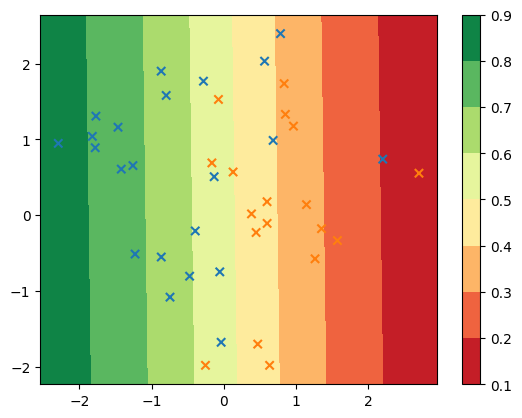

In [47]:
accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(lr, X_test, y_test)
plt.show()

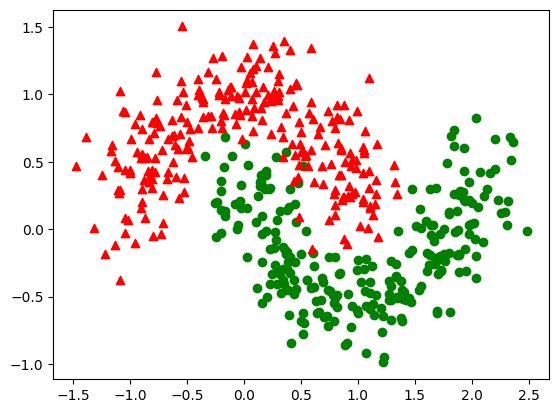

In [48]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
plot_data(X, y)

Iteration 0 Cost: [[0.69314718]]
Iteration 100 Cost: [[0.56656207]]
Iteration 200 Cost: [[0.49870649]]
Iteration 300 Cost: [[0.45760686]]
Iteration 400 Cost: [[0.43005418]]
Iteration 500 Cost: [[0.41012925]]
Iteration 600 Cost: [[0.39489553]]
Iteration 700 Cost: [[0.38275908]]
Converged at iteration 748
Accuracy: 
0.85
Report: 
              precision    recall  f1-score   support

           0       0.79      0.88      0.84        43
           1       0.90      0.82      0.86        57

    accuracy                           0.85       100
   macro avg       0.85      0.85      0.85       100
weighted avg       0.86      0.85      0.85       100

Confusion: 
    0   1
0  38   5
1  10  47


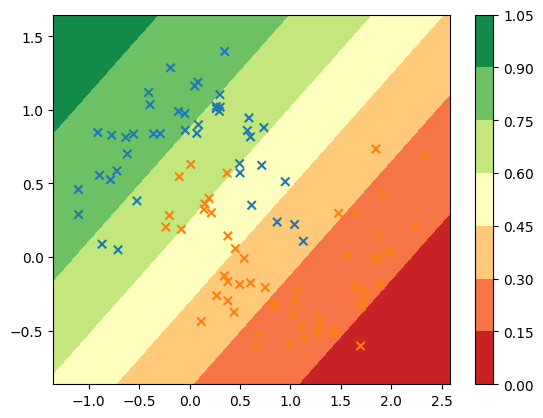

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
lr = LogisticRegression(standardize=True, learning_rate=0.01, max_iter=1000, tol=1e-4, verbose=True)
lr.fit(X_train, y_train.reshape(-1, 1))
y_test_pred = lr.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(lr, X_test, y_test)
plt.show()

Evaluate the above LogisticRegression class on datasets sats.csv and tests.csv. Consider using polynomial features when applicable.

In [50]:
data_columns = ["exam1", "exam2"]
target_column = "submitted"
X, y = load_dataset('sats.csv', data_columns, target_column)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(80, 2) (20, 2) (80, 1) (20, 1)


Iteration 0 Cost: [[0.69314718]]
Iteration 100 Cost: [[0.56920502]]
Iteration 200 Cost: [[0.49048635]]
Iteration 300 Cost: [[0.43763002]]
Iteration 400 Cost: [[0.40008243]]
Iteration 500 Cost: [[0.37210782]]
Iteration 600 Cost: [[0.35044996]]
Iteration 700 Cost: [[0.33315979]]
Iteration 800 Cost: [[0.31901072]]
Iteration 900 Cost: [[0.30719603]]
Converged at iteration 952
Accuracy: 
0.85
Report: 
              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.91      0.83      0.87        12

    accuracy                           0.85        20
   macro avg       0.84      0.85      0.85        20
weighted avg       0.86      0.85      0.85        20

Confusion: 
   0   1
0  7   1
1  2  10


C:\Users\Ректор\AppData\Local\Temp\ipykernel_19384\2209310021.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


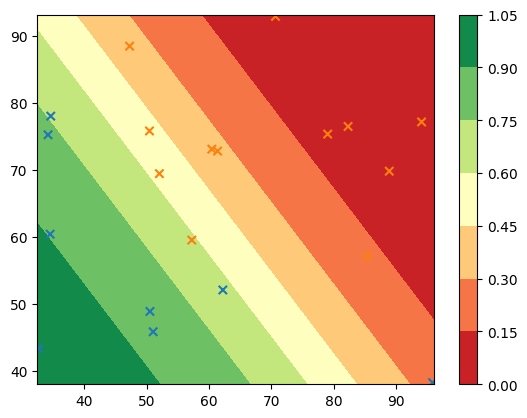

In [51]:
lr = LogisticRegression(standardize=True, learning_rate=0.01, max_iter=1000, tol=1e-4, verbose=True)
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(lr, X_test, y_test)
plt.show()

In [52]:
data_columns = ["test1", "test2"]
target_column = "passed"
X, y = load_dataset('tests.csv', data_columns, target_column)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(94, 2) (24, 2) (94, 1) (24, 1)


Iteration 0 Cost: [[0.69314718]]
Converged at iteration 1
Accuracy: 
0.4166666666666667
Report: 
              precision    recall  f1-score   support

           0       0.40      0.33      0.36        12
           1       0.43      0.50      0.46        12

    accuracy                           0.42        24
   macro avg       0.41      0.42      0.41        24
weighted avg       0.41      0.42      0.41        24

Confusion: 
   0  1
0  4  8
1  6  6


C:\Users\Ректор\AppData\Local\Temp\ipykernel_19384\2209310021.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  color_values = [colors[int(label)] for label in y]


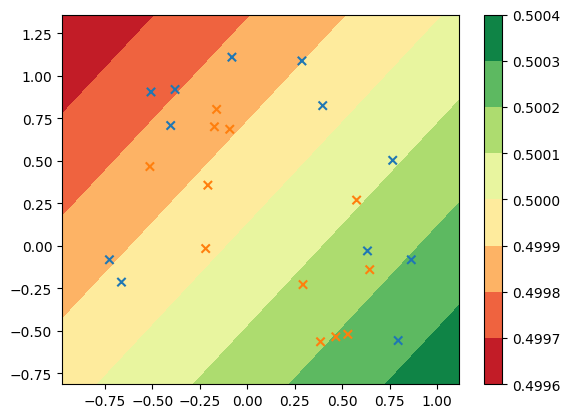

In [53]:
lr = LogisticRegression(standardize=True, learning_rate=0.01, max_iter=1000, tol=1e-4, verbose=True)
lr.fit(X_train, y_train)
y_test_pred = lr.predict(X_test)

accuracy, report, confusion = evaluate_classification(y_test, y_test_pred)
print(f"Accuracy: \n{accuracy}")
print(f"Report: \n{report}")
print(f"Confusion: \n{confusion}")
plot_decision_boundary(lr, X_test, y_test)
plt.show()